In [1]:
'''
使用ANN做车型分析
'''
# 导入包
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms

In [2]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 设置参数
num_classes = 4
LR = 0.001
num_epochs = 100

print(device)

cuda


#### 加载数据集

In [3]:
# 数据预处理
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# Prepare the dataset and dataloader
dataset = ImageFolder('../TypeData', transform=transform)
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### 定义网络结构

In [4]:
# 定义网络结构
class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(3 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
model = ANN().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

#### 训练模型

In [6]:
import torch
import torch.nn as nn

model = model.to(device) 

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
best_acc = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_correct = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_dataset)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # ---------- 验证 ----------
    model.eval()
    test_loss = 0
    test_correct = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = test_correct / len(test_dataset)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test  Loss: {test_loss:.4f}, Test  Acc: {test_acc:.4f}")

    # ---------- 保存最优模型 ----------
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), './models/best_model.pth')

Epoch [1/100]
Train Loss: 0.6688, Train Acc: 0.7363, Test  Loss: 0.2524, Test  Acc: 0.9180
Epoch [2/100]
Train Loss: 0.1648, Train Acc: 0.9505, Test  Loss: 0.1800, Test  Acc: 0.9672
Epoch [3/100]
Train Loss: 0.0800, Train Acc: 0.9753, Test  Loss: 0.1368, Test  Acc: 0.9672
Epoch [4/100]
Train Loss: 0.0699, Train Acc: 0.9753, Test  Loss: 0.2329, Test  Acc: 0.9098
Epoch [5/100]
Train Loss: 0.0736, Train Acc: 0.9780, Test  Loss: 0.1816, Test  Acc: 0.9590
Epoch [6/100]
Train Loss: 0.0453, Train Acc: 0.9863, Test  Loss: 0.1574, Test  Acc: 0.9590
Epoch [7/100]
Train Loss: 0.0215, Train Acc: 0.9945, Test  Loss: 0.1498, Test  Acc: 0.9672
Epoch [8/100]
Train Loss: 0.0078, Train Acc: 0.9973, Test  Loss: 0.1406, Test  Acc: 0.9754
Epoch [9/100]
Train Loss: 0.0036, Train Acc: 1.0000, Test  Loss: 0.1475, Test  Acc: 0.9672
Epoch [10/100]
Train Loss: 0.0025, Train Acc: 1.0000, Test  Loss: 0.1558, Test  Acc: 0.9672
Epoch [11/100]
Train Loss: 0.0018, Train Acc: 1.0000, Test  Loss: 0.1542, Test  Acc: 0.97

#### 绘制loss和accuracy的变化曲线

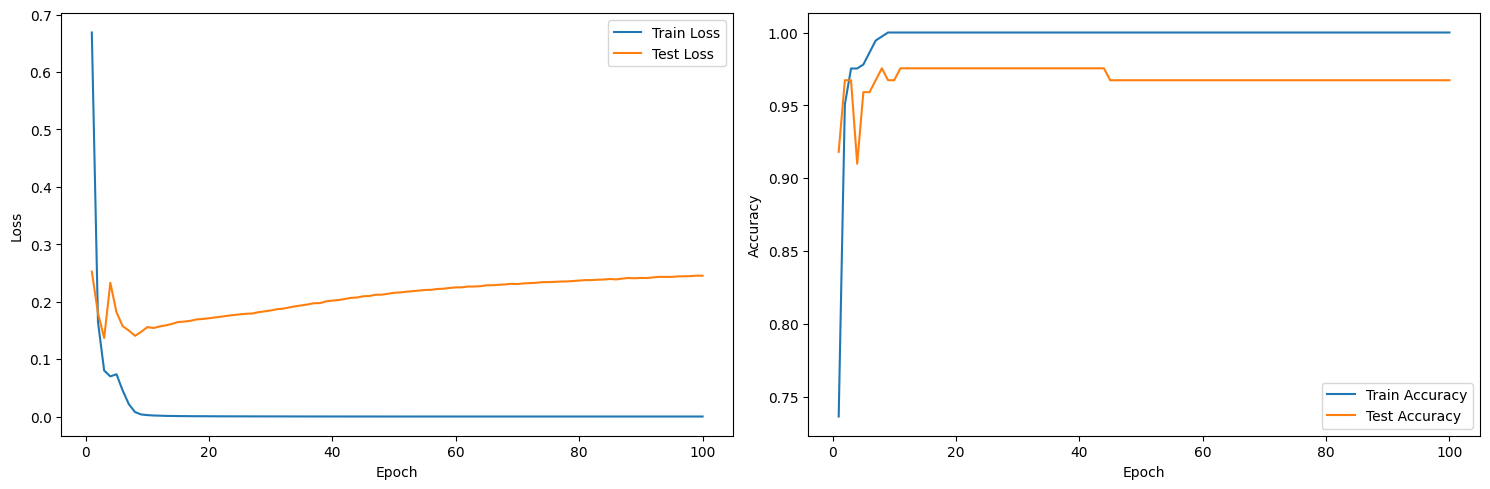

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        23
           2       1.00      1.00      1.00        34
           3       1.00      1.00      1.00        29

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [7]:
import matplotlib.pyplot as plt
# 绘制loss和accuracy的变化曲线
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_acc_list, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


from sklearn.metrics import classification_report
# 加载最佳模型
model.load_state_dict(torch.load("./models/ANN_best_model.pth"))

# 模型评估
model.eval()
predictions = []
labels_list = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        predictions.extend(predicted.cpu().numpy())
        labels_list.extend(labels.cpu().numpy())

print(classification_report(labels_list, predictions))
